# Project 3 INF264

Author: Johanna Jøsang (fak006)

In [1]:
# Imports
import pandas as pd
import numpy as np
import collections
from pprint import pprint
import matplotlib.pyplot as plt
import random
import timeit
from pprint import pprint
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


# LeNet-5 imports
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import np_utils

In [2]:
# Load data
label_data = np.genfromtxt('handwritten_digits_labels.csv', delimiter=',')
image_data = np.genfromtxt('handwritten_digits_images.csv', delimiter=',')
image_data = image_data.reshape(image_data.shape[0], 28, 28) # reshaping data

## Visualisation and preprocessing

In order to get a better understanding of the data I have been given, I start by gathering information about it.
First I would like to get a look at the shape of the data.

In [9]:
print("Label data shape:", label_data.shape)
print("Image data shape:", image_data.shape)

Label data shape: (70000,)
Image data shape: (70000, 28, 28)


As expected, the label dataset is a simple array with 70000 values, while the image dataset has 70000 2d arrays represetning the digit image.

Just to visalize the data for myself I print out a random image and its corresponding label.

At index 46946 there is a 6.0


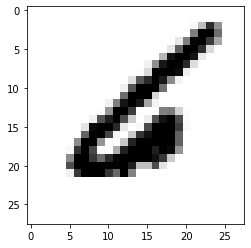

In [10]:
data_index = random.randint(0, label_data.size)
img = image_data[data_index]
plt.imshow(img, cmap="Greys")
print("At index", data_index, "there is a", label_data[data_index])

### Digit distribution

In order to find out how the data is distributed between the 10 digits, I print out the frequency, percentages and a histogram to see the distribution.

In [11]:
# Count number of examples for each digit
label_counter = collections.Counter(label_data)
print(label_counter)

# Print out the percentages for each digit
label_data_size = label_data.size
for i in range(10):
    percentage = (label_counter[i] / label_data_size) * 100
    print(i, ": ", "%.2f" % percentage, "%")
    
# Print min and max, which can easily be count ince label_counter is sorted by frequency
print("Min freq is 5 with", "%.2f" % ((label_counter[5] / label_data_size) * 100), "%")
print("Max freq is 1 with", "%.2f" % ((label_counter[1] / label_data_size) * 100), "%")

Counter({1.0: 7877, 7.0: 7293, 3.0: 7141, 2.0: 6990, 9.0: 6958, 0.0: 6903, 6.0: 6876, 8.0: 6825, 4.0: 6824, 5.0: 6313})
0 :  9.86 %
1 :  11.25 %
2 :  9.99 %
3 :  10.20 %
4 :  9.75 %
5 :  9.02 %
6 :  9.82 %
7 :  10.42 %
8 :  9.75 %
9 :  9.94 %
Min freq is 5 with 9.02 %
Max freq is 1 with 11.25 %


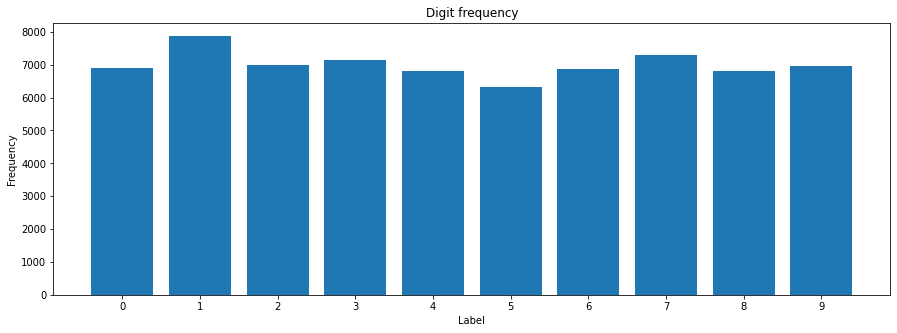

In [12]:
# Histogram
names = list(label_counter.keys())
values = list(label_counter.values())
fig = plt.figure(figsize=(15,5))
plt.bar(names, values)
plt.xticks(np.arange(0, 10))
plt.ylabel('Frequency')
plt.xlabel('Label')
plt.title("Digit frequency");

All digits have about 10% of the data, so it does not seem like the dataset needs to be balanced. The least frequent digit was 5 (9.02 %) and the most frequent was 1 (11.25 %). If our trained classifiers become much worse at categorizing 5s compared to 1s then we can perhaps go back and balance the data.

In [3]:
seed = 123
X_train_val, X_test, y_train_val, y_test = train_test_split(image_data, label_data, test_size=0.1, shuffle=True, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=True, random_state=seed)


In [4]:
def reshape_3d_to_2d(data_3d):
    number_of_samples, x_dim, y_dim = data_3d.shape
    dataset_2d = data_3d.reshape((number_of_samples,x_dim*y_dim))
    return dataset_2d

X_train_2d = reshape_3d_to_2d(X_train)
X_val_2d = reshape_3d_to_2d(X_val)
X_train_val_2d = reshape_3d_to_2d(X_train_val)

## Baseline and evaluation methods
Since we are creating classifiers, the evaluation method will be classification accuracy. For a more representative accuracy value, k-fold cross validation will be used, with k = 3. We will be using a simple decision tree classifier as a baseline.

In [5]:
kfold = KFold(n_splits=3) # initialize the kfold splitter with 3 splits

In [28]:
dTree_clf = DecisionTreeClassifier(random_state= seed)
scores = cross_val_score(dTree_clf, X_train_val_2d, y_train_val, cv=3)

In [29]:
print("Cross validation score for decision tree classifier is:", np.mean(scores))

Cross validation score for decision tree classifier is: 0.8635396825396825


## Random forest classifier
The classifier being used is sklearn's Random Forest Classifier: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [30]:
val_acc_at_depth = {} # Dictionary for keeping track of depth vs accuracy
train_acc_at_depth = {} # Dictionary for keeping track of depth vs accuracy
for i in range(1,30):
    clf = RandomForestClassifier(max_depth = i)
    #cross_val_scores = cross_val_score(clf, X_train_val_2d, y_train_val)
    clf.fit(X_train_2d, y_train)
    train_score = clf.score(X_train_2d, y_train)
    val_score = clf.score(X_val_2d, y_val)
    #mean_cross_val_score = np.mean(cross_val_scores)
    print("Precision at depth", i , "is val:", val_score, "train", train_score)
    #acc_at_depth[i] = mean_cross_val_score 
    train_acc_at_depth[i] = train_score
    val_acc_at_depth[i] = val_score

Precision at depth 1 is val: 0.5097619047619047 train 0.5129761904761905
Precision at depth 2 is val: 0.6461111111111111 train 0.6521428571428571
Precision at depth 3 is val: 0.7437301587301587 train 0.7462896825396825
Precision at depth 4 is val: 0.8202380952380952 train 0.8253968253968254
Precision at depth 5 is val: 0.8587301587301587 train 0.8609722222222222
Precision at depth 6 is val: 0.8864285714285715 train 0.8931150793650794
Precision at depth 7 is val: 0.905079365079365 train 0.9142460317460317
Precision at depth 8 is val: 0.9236507936507936 train 0.9358531746031746
Precision at depth 9 is val: 0.9351587301587302 train 0.9517063492063492
Precision at depth 10 is val: 0.9441269841269841 train 0.9668055555555556
Precision at depth 11 is val: 0.952936507936508 train 0.9803174603174604
Precision at depth 12 is val: 0.9565873015873015 train 0.9886507936507937
Precision at depth 13 is val: 0.9602380952380952 train 0.9936507936507937
Precision at depth 14 is val: 0.9635714285714285 

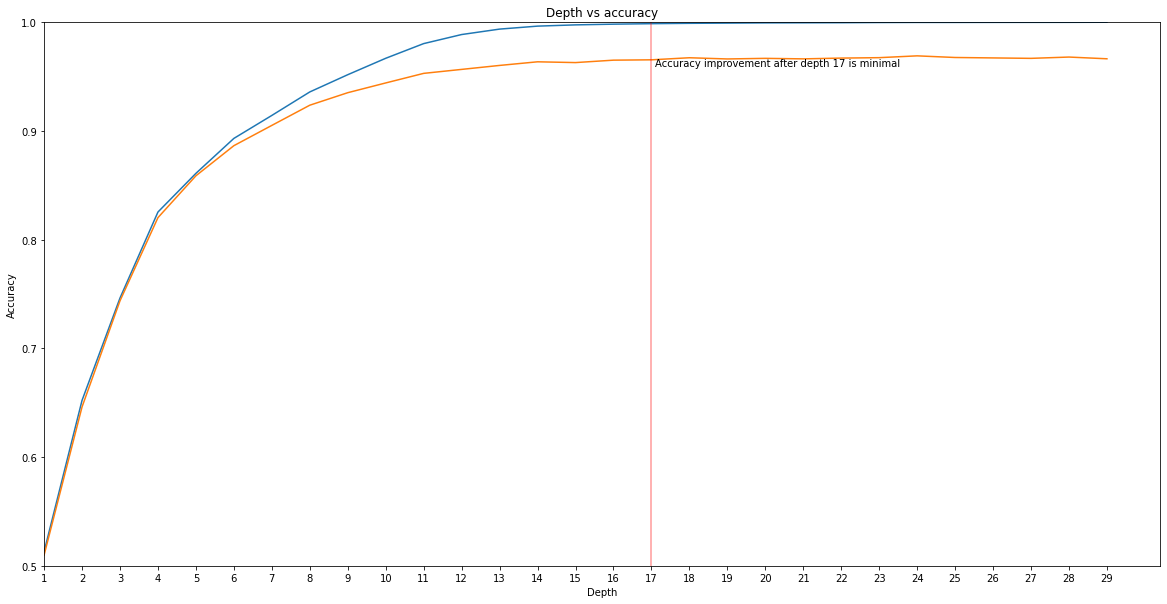

In [31]:
x = train_acc_at_depth.keys()
train_y = train_acc_at_depth.values()
val_y = val_acc_at_depth.values()
fig = plt.figure(figsize=(20,10))
plt.plot(x,train_y)
plt.plot(x,val_y)
plt.axvline(x=17, ymin=0, ymax=1, color = 'r', alpha = 0.4)
plt.text(17.1, 0.96, "Accuracy improvement after depth 17 is minimal")
plt.xlim(left=13)
plt.ylim(bottom=0.5, top = 1)
plt.title("Depth vs accuracy")
plt.xticks(np.arange(1, 30, 1))
plt.ylabel('Accuracy')
plt.xlabel('Depth')
plt.show()

While the accuracy did seem increase as max_depth was increased, the improvement was so marginal it did not justify the increased runtime. Hence max_depth was simply set to 30.

In [32]:
rf = RandomForestClassifier(random_state = 123)
print('Possible parameters for random forest:')
pprint(rf.get_params())

Possible parameters for random forest:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}


After maually testing out a couple of different hyperparameters to get an idea of how they impacted to accuracy, it became clear that only a small subset of the combinations would be able to be tested. Number of estimators, max_features, min_samples_leaf, and min_samples_split were chosen as they seemed to have the most effect on the accuracy rate.

In [33]:
n_estimators = range(50, 400, 50)
max_features = ['auto', 'sqrt']
#max_depth = range(10, 31, 5)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
              # 'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
pprint(random_grid)

{'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': range(50, 400, 50)}


In [34]:
rf = RandomForestClassifier(max_depth = 30)
start = timeit.default_timer()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=123, n_jobs = -1, return_train_score=True)
rf_random.fit(X_train_val_2d, y_train_val)
stop = timeit.default_timer()
runtime = ((stop-start) / 60.0)
print("Runtime was: %.2f" %runtime, "minutes")    

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 65.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 132.2min finished


Started


In [35]:
print("The best hyperparameter values found are:")
rf_random.best_params_

The best hyperparameter values found are:


{'n_estimators': 350,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt'}

In [39]:
rf_clf = RandomForestClassifier(n_estimators =  300, max_depth = 30, min_samples_split = 2, min_samples_leaf = 1, max_features = 'auto')
score = np.mean(cross_val_score(dTree_clf, X_train_val_2d, y_train_val, cv=3))
print("Accuracy for optimal random forest classifier is: %.2f" %score)

Accuracy for optimal random forest classifier is: 0.86


## Convolutional Neural Network (LeNet-5)

In [12]:
# Preprocessing

# Make image data 4-dimensional
X_train_val_4d = X_train_val.reshape(X_train_val.shape[0], 28, 28, 1)
X_train_4d = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_val_4d = X_val.reshape(X_val.shape[0], 28, 28, 1)
X_test_4d = X_test.reshape(X_test.shape[0], 28, 28, 1)

# convert label data to one-hot encoding
y_train_val_onehot = np_utils.to_categorical(y_train_val, 10)
y_train_onehot = np_utils.to_categorical(y_train, 10)
y_val_onehot = np_utils.to_categorical(y_val, 10)
y_test_onehot = np_utils.to_categorical(y_test, 10)

In [22]:
def leNet_5_setup(activation_function, learning_rate):    
    # Initialize an empty sequential model
    leNet_model = Sequential()
    # Convolutional Layer
    leNet_model.add(Conv2D(filters = 6, kernel_size=(3, 3), strides=(1, 1), activation= activation_function, input_shape=(28,28,1), padding= 'same'))
    # Pooling
    leNet_model.add(AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding= 'same'))
    #Convolutional Layer
    leNet_model.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1), activation= activation_function, padding= 'valid'))
    # Pooling
    leNet_model.add(AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding= 'valid'))
    # Connected Convolutional Layer
    leNet_model.add(Conv2D(120, kernel_size=(3, 3), strides=(1, 1), activation= activation_function, padding= 'valid'))
    # Flattening
    leNet_model.add(Flatten())
    # Fully Connected Layer
    leNet_model.add(Dense(84, activation= activation_function))
    #Output layer
    leNet_model.add(Dense(10, activation= 'softmax'))
    # Compile the model
    leNet_model.compile(loss= 'categorical_crossentropy', optimizer = SGD(lr = learning_rate), metrics=['accuracy']) 

    return leNet_model

In [92]:
epochs = 20
batch_size = 32
learning_rates = [0.001, 0.01, 0.1]
accuracies_dict = {}

kfold = KFold(n_splits=3)
acc_dict = {}
start = timeit.default_timer()
for l_rate in learning_rates:
    leNet_model = leNet_5_setup(activation_function = 'tanh', learning_rate = l_rate)
    train_acc_per_fold = []
    val_acc_per_fold = []
    for train_indices, test_indices in kfold.split(X_train_val_4d, y_train_val_onehot):
        X_train_set = X_train_val_4d[train_indices]
        y_train_set = y_train_val_onehot[train_indices]
        X_test_set = X_train_val_4d[test_indices]
        y_test_set = y_train_val_onehot[test_indices]
        leNet_history = leNet_model.fit(X_train_set, y_train_set, validation_data=(X_test_set, y_test_set), shuffle=False, batch_size = batch_size, epochs = epochs, verbose = 1) 
        train_acc_per_fold.append(leNet_history.history['accuracy'][-1])
        val_acc_per_fold.append(leNet_history.history['val_accuracy'][-1])
    accuracies_dict["L-rate " + str(l_rate) +' train accuracy'] = np.mean(train_acc_per_fold)
    accuracies_dict["L-rate " + str(l_rate) + ' val accuracy'] = np.mean(val_acc_per_fold)
stop = timeit.default_timer()
runtime = ((stop-start) / 60.0)
print("Runtime was: %.2f" %runtime, "minutes")    

Epoch 1/20
1313/1313 [==============================] - 146s 111ms/step - loss: 0.5005 - accuracy: 0.8823 - val_loss: 0.2995 - val_accuracy: 0.9236
Epoch 2/20
1313/1313 [==============================] - 145s 110ms/step - loss: 0.2582 - accuracy: 0.9319 - val_loss: 0.2225 - val_accuracy: 0.9425
Epoch 3/20
1313/1313 [==============================] - 137s 104ms/step - loss: 0.1990 - accuracy: 0.9467 - val_loss: 0.1793 - val_accuracy: 0.9528
Epoch 4/20
1313/1313 [==============================] - 138s 105ms/step - loss: 0.1627 - accuracy: 0.9563 - val_loss: 0.1508 - val_accuracy: 0.9609
Epoch 5/20
1313/1313 [==============================] - 134s 102ms/step - loss: 0.1390 - accuracy: 0.9630 - val_loss: 0.1330 - val_accuracy: 0.9659
Epoch 6/20
1313/1313 [==============================] - 134s 102ms/step - loss: 0.1232 - accuracy: 0.9675 - val_loss: 0.1210 - val_accuracy: 0.9680
Epoch 7/20
1313/1313 [==============================] - 135s 103ms/step - loss: 0.1121 - accuracy: 0.9705 - val_

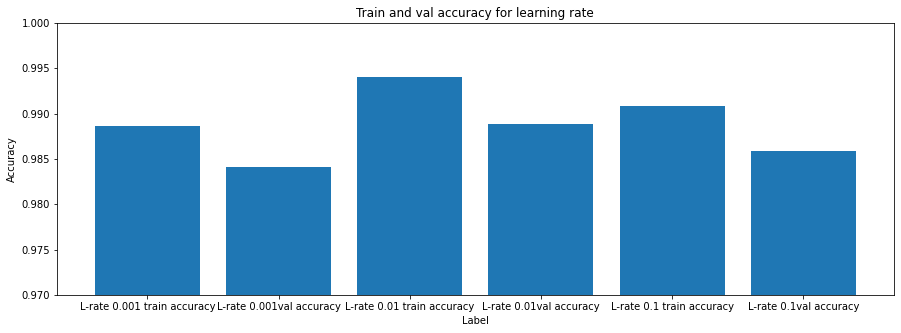

In [95]:
# Histogram
lr_names = list(accuracies_dict.keys())
lr_values = list(accuracies_dict.values())
fig = plt.figure(figsize=(15,5))
plt.ylim(bottom=0.97, top = 1)
plt.bar(lr_names, lr_values)
#plt.xticks(np.arange(0, 10))
plt.ylabel('Accuracy')
plt.xlabel('Label')
plt.title("Train and val accuracy for learning rate");

In [45]:
print("Accuracy for optimal learning rate is: %.2f" %accuracies_dict['L-rate 0.01 val accuracy'])

KeyError: 'L-rate 0.01 val accuracy'

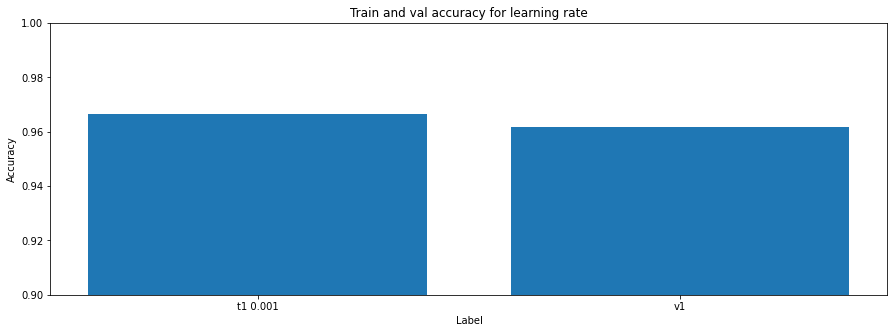

In [60]:
train_one = np.mean(train_acc_per_fold[:3])
train_two = np.mean(train_acc_per_fold[3:6])
train_three = np.mean(train_acc_per_fold[6:9])
val_one = np.mean(val_acc_per_fold[:3])
val_two = np.mean(val_acc_per_fold[3:6])
val_three = np.mean(val_acc_per_fold[6:9])
names = ['t1 0.001', 'v1', 't2 0.01', 'v2', 't3 0.1', 'v3']
values = [train_one, val_one, train_two, val_two, train_three, val_three]
fig = plt.figure(figsize=(15,5))
plt.ylim(bottom=0.90, top = 1)
plt.bar(names, values)
#plt.xticks(np.arange(0, 10))
plt.ylabel('Accuracy')
plt.xlabel('Label')
plt.title("Train and val accuracy for learning rate");

## K-nearest neighbour
The classifier being used is sklearn's KNeiboursClassifier: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html


First we check an initial round of training and validation to see how much time is required. Based on these results we can determine how many hypterparameters it would be feasible to test.

In [13]:
KNN_clf = KNeighborsClassifier(n_neighbors=3, n_jobs = -1)
start = timeit.default_timer()
KNN_clf.fit(X_train_2d, y_train)
stop = timeit.default_timer()
print("Train runtime for is: %.2f", %stop-start, "seconds")
start = timeit.default_timer()
val_score2 = KNN_clf.score(X_val_2d, y_val)
stop = timeit.default_timer()
print("Validation runtime  is: %.2f", %stop-start, "seconds")

Train runtime for onehot is: 26.335255900000448
Val runtime for onehot is: 302.27646749999985
0.9691269841269842


It takes about half a minute to train the classifier, and about 5 minutes to get a validation score. With k-fold, and k = 3, this would be about 15 minutes per hyperparameter combination. Since this is quite time consuming, we will only check different values for the "number of neighbours" hyperparameter.

In [6]:
print('Possible parameters for KNN:')
pprint(KNN_clf.get_params())

Possible parameters:
{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 3,
 'p': 2,
 'weights': 'uniform'}


In [6]:
n_neighbours = [5, 9, 15]
KNN_acc_dict = {}

start = timeit.default_timer()
for n in n_neighbours:
    print("Checking no. neighbours = ", n)
    train_acc_per_fold = []
    val_acc_per_fold = []
    KNN_clf = KNeighborsClassifier(n_neighbors= n, n_jobs = -1)
    fold_n = 1
    for train_indices, test_indices in kfold.split(X_train_val_2d, y_train_val):
        print("Fold number", fold_n)
        X_train_set = X_train_val_2d[train_indices]
        y_train_set = y_train_val[train_indices]
        X_test_set = X_train_val_2d[test_indices]
        y_test_set = y_train_val[test_indices]
        KNN_clf.fit(X_train_set, y_train_set)
        train_acc = KNN_clf.score(X_train_set, y_train_set)
        train_acc_per_fold.append(train_acc)
        val_acc = KNN_clf.score(X_test_set, y_test_set)
        val_acc_per_fold.append(val_acc)
        fold_n += 1
    KNN_acc_dict["No. neigh. " + str(n) +' train acc'] = np.mean(train_acc_per_fold)
    KNN_acc_dict["No. neigh. " + str(n) + ' val acc'] = np.mean(val_acc_per_fold)
    
stop = timeit.default_timer()
runtime = ((stop-start) / 60.0)
print("Runtime was: %.2f" %runtime, "minutes")

Checking no. neighbours =  5
Checking no. neighbours =  9
Checking no. neighbours =  15
Runtime was: 187.60 minutes


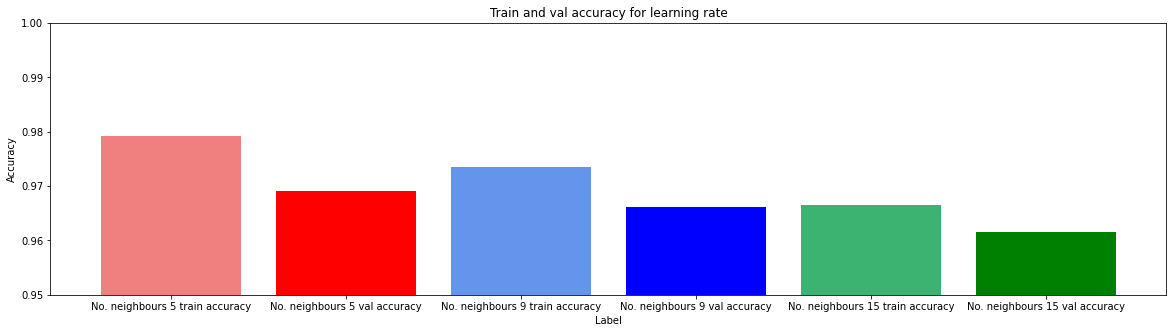

In [58]:
# Histogram
KNN_names = list(KNN_acc_dict.keys())
KNN_values = list(KNN_acc_dict.values())
fig = plt.figure(figsize=(20,5))
plt.ylim(bottom=0.95, top = 1)
#plt.bar(names, values)
plt.bar(KNN_names, KNN_values, width = 0.8, color=['lightcoral', 'red', 'cornflowerblue', 'blue', 'mediumseagreen', 'green'])
#plt.xticks(np.arange(0, 10))
plt.ylabel('Accuracy')
plt.xlabel('Label')
plt.title("Train and val accuracy number of neighbours");

In [53]:
optimal_KNN_score = accuracies_dict['No. neighbours 5 val accuracy']
print("Accuracy for optimal number of neigbours, 15, is: %.3f" %optimal_KNN_score)

Accuracy for optimal number of neigbours, 15, is: 0.969


0.9690952380952381


Out of the ones tested, the optimal number of neighbours was __.

## Selection Results

In [30]:
epochs = 20
batch_size = 32
leNet_optimal_model = leNet_5_setup(activation_function = 'tanh', learning_rate = 0.01)
leNet_opt_history = leNet_optimal_model.fit(X_train_4d, y_train_onehot, validation_data=(X_test_4d, y_test_onehot), shuffle=False, batch_size = batch_size, epochs = epochs, verbose = 1) 
train_acc = leNet_opt_history.history['accuracy'][-1]
test_acc = leNet_opt_history.history['val_accuracy'][-1]

Epoch 1/20
1575/1575 [==============================] - 126s 80ms/step - loss: 0.1678 - accuracy: 0.9545 - val_loss: 0.1032 - val_accuracy: 0.9700
Epoch 2/20
1575/1575 [==============================] - 124s 79ms/step - loss: 0.0789 - accuracy: 0.9780 - val_loss: 0.0838 - val_accuracy: 0.9754
Epoch 3/20
1575/1575 [==============================] - 119s 76ms/step - loss: 0.0609 - accuracy: 0.9837 - val_loss: 0.0740 - val_accuracy: 0.9779
Epoch 4/20
1575/1575 [==============================] - 119s 76ms/step - loss: 0.0496 - accuracy: 0.9862 - val_loss: 0.0718 - val_accuracy: 0.9793
Epoch 5/20
1575/1575 [==============================] - 125s 79ms/step - loss: 0.0431 - accuracy: 0.9882 - val_loss: 0.0642 - val_accuracy: 0.9810
Epoch 6/20
1575/1575 [==============================] - 123s 78ms/step - loss: 0.0371 - accuracy: 0.9907 - val_loss: 0.0628 - val_accuracy: 0.9811
Epoch 7/20
1575/1575 [==============================] - 120s 76ms/step - loss: 0.0335 - accuracy: 0.9912 - val_loss: 0

In [31]:
print("Accuracy of LeNet-5 model on new unseen test data:", test_acc)

Accuracy of LeNet-5 model on new unseen test data: 0.9844285845756531
